# Syncing API (`.sync`)

Estimated reading time: 15'

```{admonition} Info
This guide is destined for data owners.
```

## What you'll learn

This guide's objective is to help you become familiar with how syncing works in a **high-side**/**low-side** scenario, where two servers with different risks levels are used together under a Datasite.

## Introduction

Air-gapped deployments carry the lowest security risks to data owners. They rely on a **low-side server** (which has no confidential information and is accessible risk-free by untrusted parties) and a **high-side server** (which is air-gapped and only reachable by data owners).

This type of physical isolation of the high-side server from the unsecured network (such as public Internet or an unsecured local area) is, in fact, the maximum protection one server can have.

Syncing is crucial in streamlining the process of manually transferring information between the low-side server and the high-side server.

```{warning}
This feature is in active development and currently in beta, meaning it may be unstable and prone to issues in certain scenarios.
```

### Data Transfers

There are two different types of data transfers occuring in a low-side/high-side deployment:

- *High-side to low-side data transfer (explicit data release)*: Due to the sensitive nature of the data, the release of any information from the high-side requires an explicit approval from the data owner. The synchronization feature streamlines the process by fetching the information you need to review and quickly sending it over.

- *Low-side to high-side data transfer (security review)*: The low-side works as an entry point for projects and user code to the secure private execution environment (high-side). However, since these come from untrusted parties, they might introduce harmful code that could be executing side-channel attacks, leaking private data, or compromising the integrity of the high-side environment. Consequently, the sync allows you to properly do the security review before transferring the data to the high-side.

These are both duties to be carried by the *data owner*, given that a **direct connection between low-side and high-side represents an attack vector for sensitive data**. This is also the reason why private assets cannot get copied over automatically, and **only the mock assets** can exist on the low-side (after a partial sync).

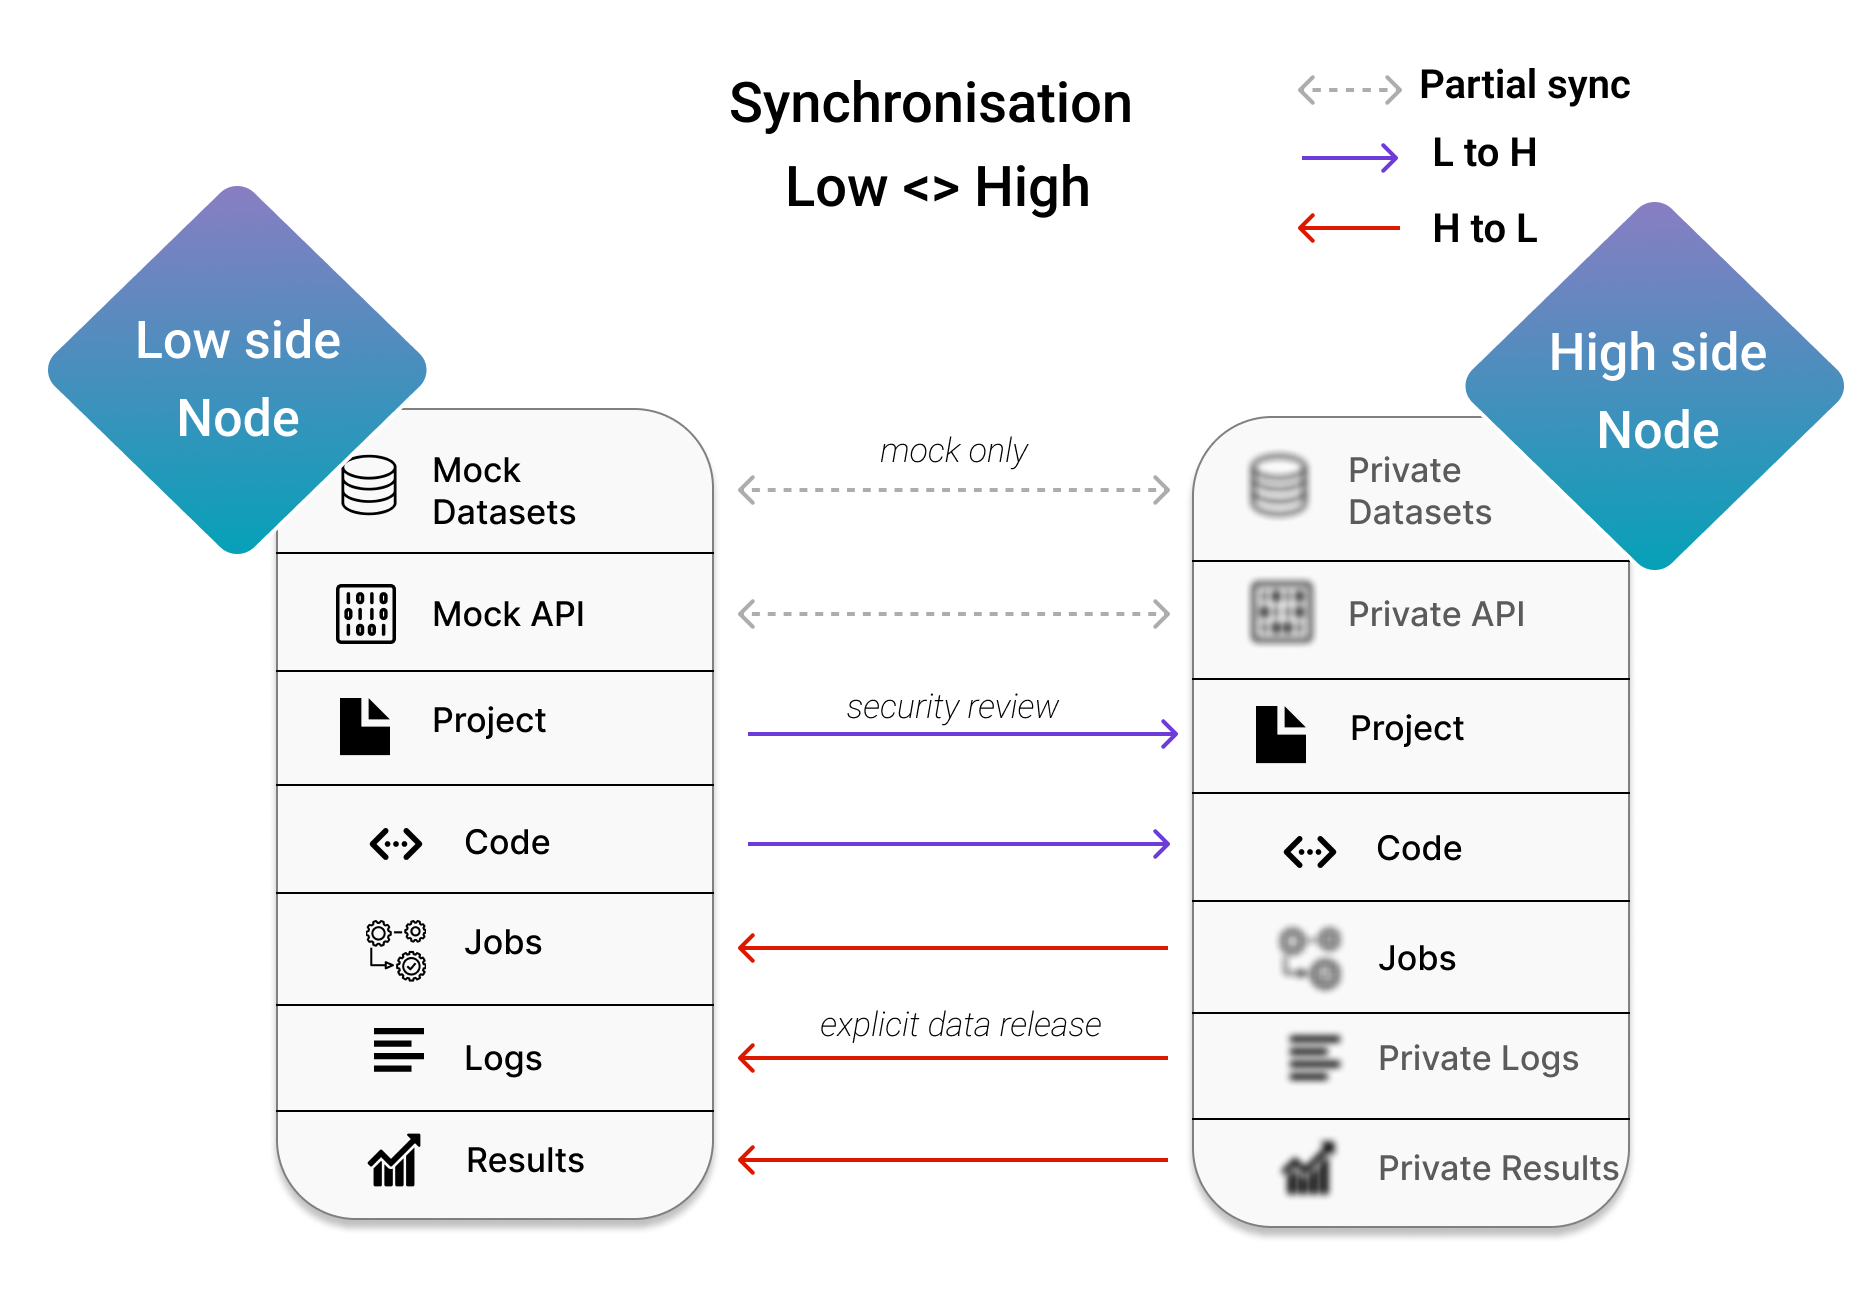

## How does sync work?

Syncronization is done via **batches**.

A batch represents a set of changes to the server's objects. PySyft structures these changes in a tree format, with the root object's changes at the base and the changes to dependent objects branching out from there.

For example, a user's Syft Function is a root object, while the executions of that function (jobs) depend on it. Similarly, in a batch, a job can be the root object, with the logs and results of that job as the child objects.

```{admonition} How it works
As a rule of thumb, a batch has only one level of dependency depth. However, batches can also depend on each other, forming a tree-like structure.
```

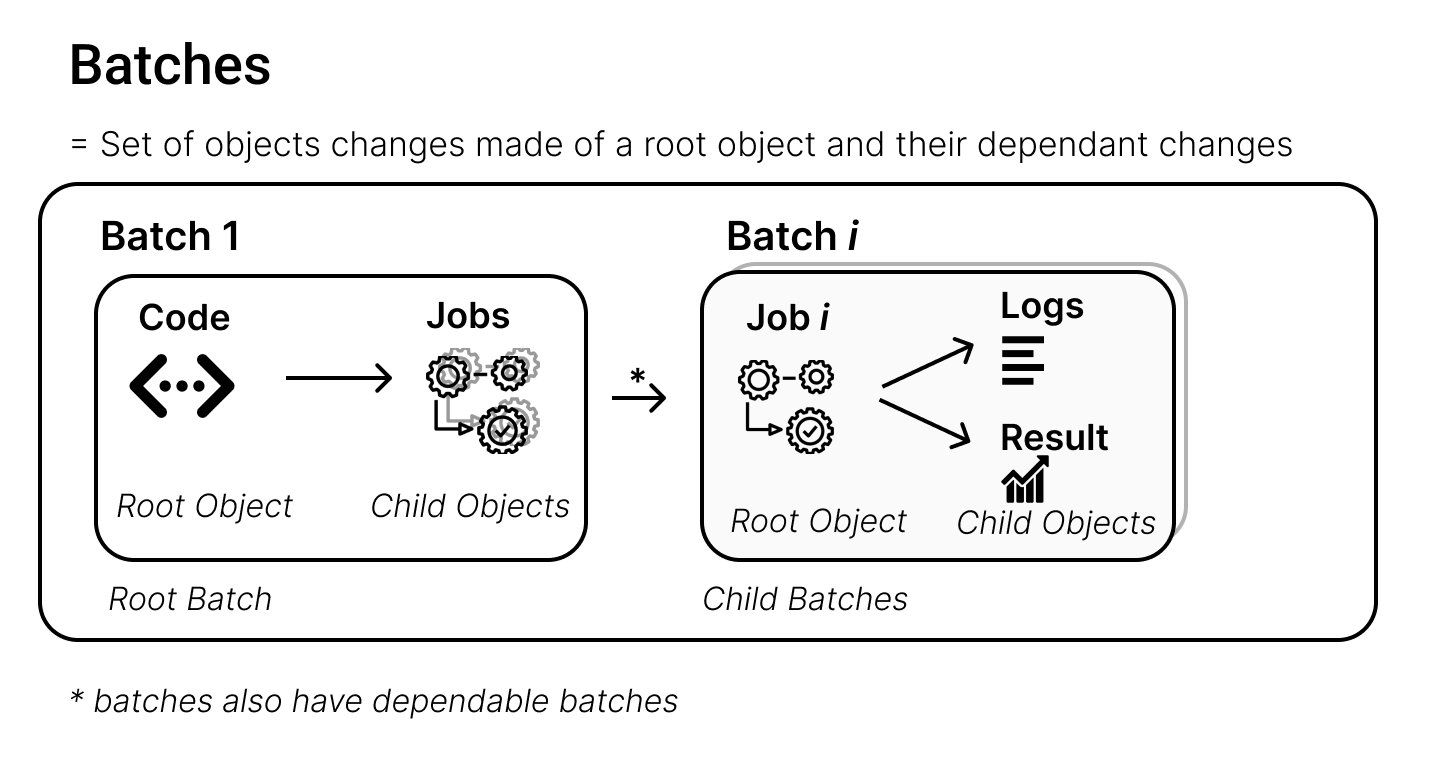

### Mock Setup

In [ ]:
import syft as sy
import pandas as pd

# launch a test setup
server_low = sy.orchestra.launch(
    name="low_domain",
    port="auto",
    dev_mode=False,
    reset=True,
    server_side_type="low",
    create_producer=True,
    n_consumers=1
)

server_high = sy.orchestra.launch(
    name="high_domain",
    port="auto",
    dev_mode=False,
    reset=True,
    create_producer=True,
    n_consumers=1
)

# log in (don't forget to change the credentials in a real-life scenario)
client_low = sy.login(
    email="info@openmined.org",
    password="changethis",
    port=server_low.port
)

client_high = sy.login(
    email="info@openmined.org",
    password="changethis",
    port=server_high.port
)

main_contributor = sy.Contributor(name="Jeffrey Salazar", role="Uploader", email="jsala@ailab.com")

low_side_asset = sy.Asset(
    name="asset_name",
    data=[1,2,3], # real data
    mock=[4,5,6], # mock data
    contributors=[main_contributor],
)

high_side_asset = sy.Asset(
    name="asset_name",
    data=[1,2,3],
    mock=[1,2,3],
    contributors=[main_contributor],
)

low_side_dataset = sy.Dataset(
    name="Dataset name",
    description="**Dataset description**",
    asset_list=[low_side_asset],
    contributors=[main_contributor],
)

high_side_dataset = sy.Dataset(
    name="Dataset name",
    description="**Dataset description**",
    asset_list=[high_side_asset],
    contributors=[main_contributor],
)

client_low.upload_dataset(low_side_dataset)
client_high.upload_dataset(high_side_dataset)

client_low.settings.allow_guest_signup(enable=True)

client = sy.login_as_guest(port=server_low.port).register(email="scientist@test.com", password="123", name="Curious Scientist", password_verify="123",  institution="")
client = sy.login(port=server_low.port, email="scientist@test.com", password="123")

# User proposes a research project
project = sy.Project(
    name="Sum of numbers",
    description="I want to research the sum of the data points.",
    members=[client]
)

project.send()

# User proposes the research code that implements the project
@sy.syft_function_single_use(data=client.datasets[0].assets[0])
def sum_of_numbers(data):
    return sum(data)

project.create_code_request(sum_of_numbers, client)  

@sy.syft_function_single_use(data=client.datasets[0].assets[0])
def malicious_user_code(data):
    return data

# User submits the code requests alongside the project and awaits approval
project.create_code_request(malicious_user_code, client)

## Low-Side to High-Side Sync

Syncronising data from the low-side to the high-side is useful for transferring the requests (and their code) for execution on the high-side. 

To review the code and decide which of the servers to use, we can use the `sync` function:

In [ ]:
sy.sync(client_low, client_high)

This function starts by fetching the latest state updates since the last sync from each of the two nodes and then structures the differences in a table, like above. By using the `Next` and `Previous` buttons, a user can go back and forth between unsynced changes and sync them with `Apply Selected Changes`.

The structure of the widget is detailed in the screenshot below.

```{admonition} Reminder
It is important to remember that **dependant changes always sync together with the root object** in a batch.
```

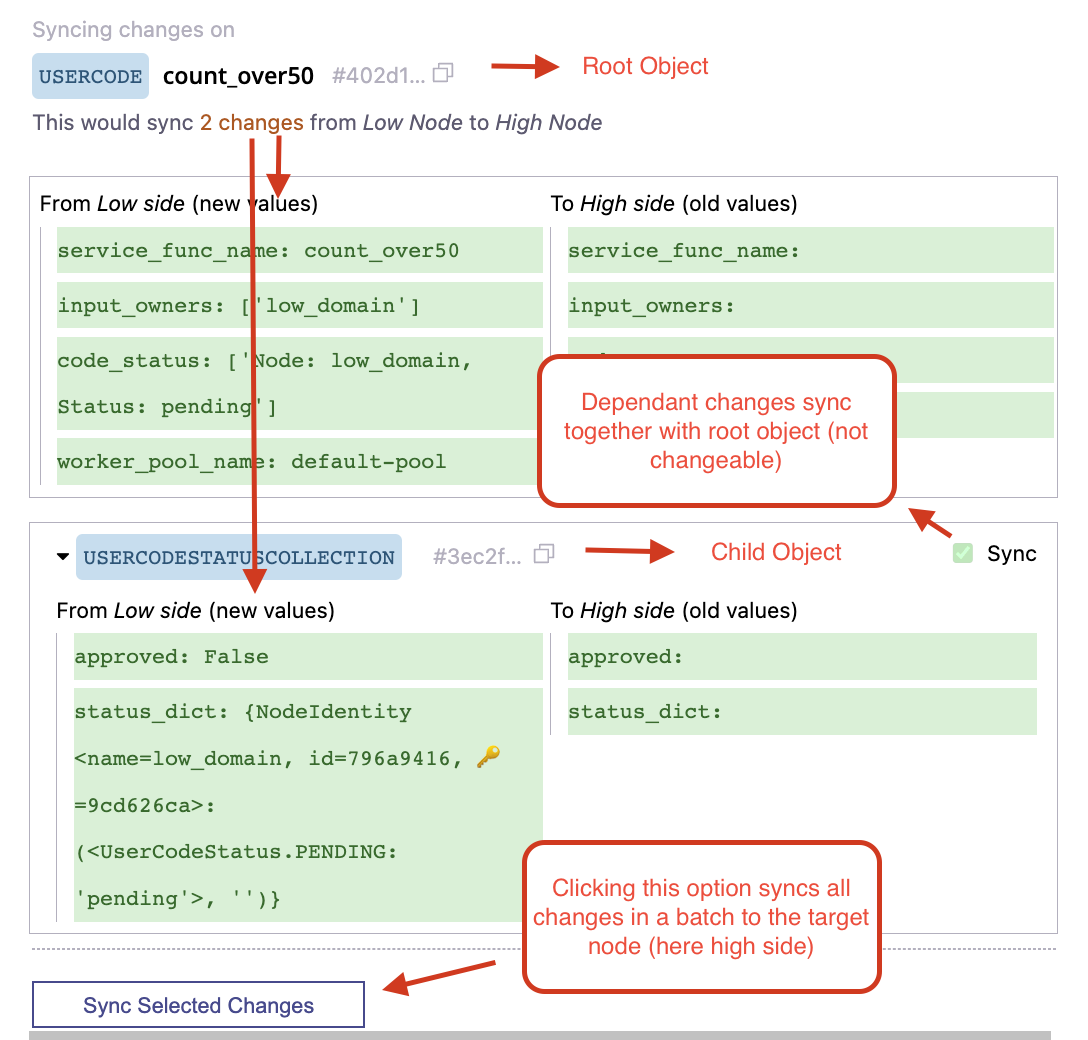

### Filtering and Other Widget Options

You can filter batches by email via `filter_by_email` when computing the diff, to make it easier to triage the syncing operations. 

A few more parameters are available to customize the view:

- `hide_usercode`: the user's code is shown to the user by default, as part of the request, to make the review process easier; setting this to `False` will separate the view for readability, but they remain part of the same batch.

- `include_ignored`: batches that you do not want to sync can be ignored and hidden from all diff views; setting this to `True` allows the user to sync changes that were previously ignored.

- `include_type`: a list of types you would like to be included in the widget. Can be either a string (`request`, `twinapiendpoint`) or the type.

In [ ]:
widget = sy.sync(client_low, client_high, filter_by_email="scientist@test.com", include_types=["request"])
widget

### Approving Changes Programatically

This is possible by manipulating the all-batches widget, which exposes the following methods:

- `.click_sync(index)`: synchronise the batch at the given index. This will never synchronise private information, which requires explicit action.

- `.click_share_all_private_data(index)`:  synchronise the batch at the given index and the private information stored, such as computation results and logs. 

```{warning}
**Proceed with care when using the latter**, as sharing the result will notify the researcher that their request was approved and the result was deposited.
```

You can also index the widget itself, which enables the same methods, but at a batch level. Assuming we only want to sync the non-malicious one, we can do:

In [ ]:
widget[0].click_sync()

### Ignoring a Batch

In this example scenario, we want to ignore the other code request as we are **sure** we do not ever want to move that over to the high-side, as it contains malicious code.

```{admonition} Info
If you ignore a batch that has dependant batches, all batches are ignored together.
```

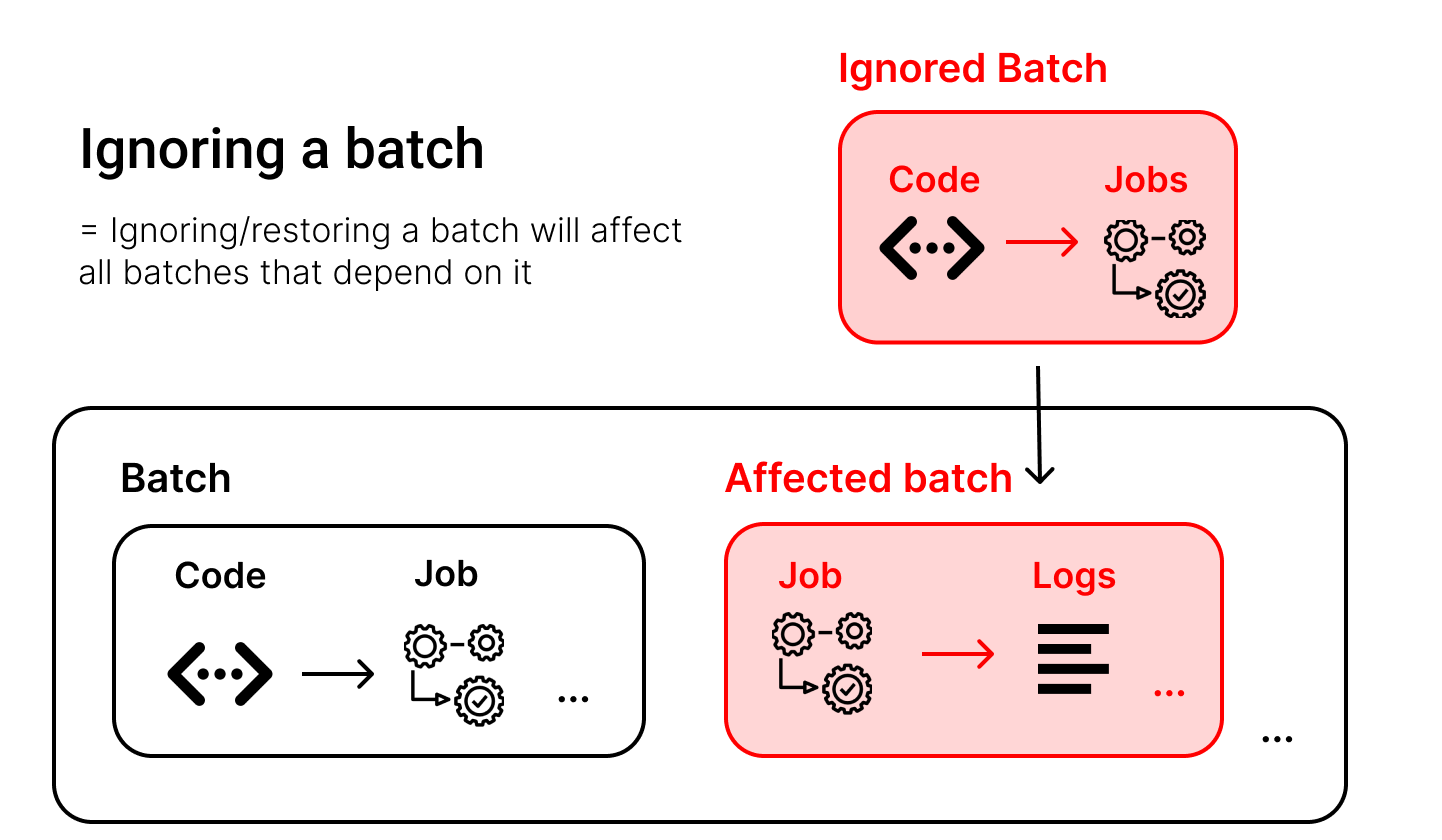

Ignoring is possible **only on batches that were not synced**, as such:

In [ ]:
widget.batches

In [ ]:
widget.batches[1].ignore()

In [ ]:
widget.batches

## High-Side to Low-Side Sync

In [ ]:
client_high.requests

Let's execute it and after sync the code alongisde the job's result.

In [ ]:
job = client_high.code.sum_of_numbers(data=client_high.datasets[0].assets[0], blocking=False)
job

In [ ]:
job.wait().get()

Now, we would like to share the result above with the low-side, so we can answer the data scientists' request:

In [ ]:
widget = sy.sync(client_high, client_low)
widget

```{warning} Sharing private data
The widget has special checkboxes for objects that could leak private information, usually results of computations on private data and their logs. 

Sharing results and logs can be decided on independently (`Share real data` for logs, and `Share real data and approve` for results). However, if you decide to share the result (the `ActionObject` resulted from the computation), this will implicitly approve the request and make the result available to the user. This is to restrict data owners from sharing private data to the low-side without explicitly sharing it to an user, as the low-side is more vulnerable.
```   

Approving the result programatically is similar to what we saw before:

In [ ]:
widget.click_share_all_private_data(0) # approving the sharing of private data for the batch at index 0
widget.click_sync(0)

### Auto-Approval for Shared Results

In [ ]:
client_low.requests

If ignored, the data owner needs to deny the request manually as such:

In [ ]:
client_low.requests[1].deny(reason="Malicious code")

In [ ]:
client_low.code.sum_of_numbers.jobs

Voilà! This should be a useful tool for data owners when it comes to transferring data responsibly between the two servers.

Since this feature is still in beta, expect new improvements soon!